<a href="https://colab.research.google.com/github/faranakGeo/skills-introduction-to-github/blob/main/NN_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Rock Physics Regression: Predicting $V_p$ from Porosity, Depth, Fluid, and Lithology

**Objective:** Practice neural network training concepts (train/val/test split, loss/metrics, activation functions, regularization, optimizers, early stopping) on a **rock physics** regression task.

We generate synthetic data using a simplified **Wyllie time-average** style relation (on slowness) with realistic modifiers for depth/compaction, fluid type (brine vs gas), and lithology (sandstone, limestone, shale).

**Target:** Compressional-wave velocity $V_p$ (km/s).  
**Features:** porosity $\phi$ (fraction), depth (km), lithology (one-hot), fluid (one-hot).


In [3]:

import math, random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')


## 1) Synthetic Data Generation

We use a Wyllie-style time-average for slowness:  
\[
s = \frac{\phi_\mathrm{eff}}{V_f} + \frac{1-\phi_\mathrm{eff}}{V_m}, \quad V_p = \frac{1}{s}
\]

- Effective porosity: $\phi_\mathrm{eff} = \phi \exp(-k\,\text{depth})$ (compaction; $k \approx 0.2$ / km)  
- Matrix velocity $V_m$ depends on lithology: sandstone (5.5), limestone (6.0), shale (4.0) km/s  
- Fluid velocity $V_f$ depends on fluid: brine (1.5), gas (0.35) km/s  
- Depth trend: add a small linear increase with depth to mimic pressure effects  
- Add small Gaussian noise


In [4]:

def generate_vp_dataset(
    n=4000,
    phi_range=(0.02, 0.35),          # total porosity
    depth_range=(0.1, 3.0),          # km
    k_compaction=0.2,                # 1/km
    noise_std=0.05,                  # km/s
):
    # Categories
    lithologies = ['sandstone', 'limestone', 'shale']
    fluids = ['brine', 'gas']

    Vm_map = {'sandstone': 5.5, 'limestone': 6.0, 'shale': 4.0}  # km/s
    Vf_map = {'brine': 1.5, 'gas': 0.35}                         # km/s

    X_list = []
    y_list = []

    for _ in range(n):
        # Sample inputs
        phi = np.random.uniform(*phi_range)                   # fraction
        depth = np.random.uniform(*depth_range)               # km
        lith = random.choice(lithologies)
        fluid = random.choice(fluids)

        Vm = Vm_map[lith]
        Vf = Vf_map[fluid]

        # Effective porosity after compaction with depth
        phi_eff = phi * np.exp(-k_compaction * depth)
        phi_eff = np.clip(phi_eff, 0.0, 0.6)

        # Wyllie time-average on slowness
        s = (phi_eff / Vf) + ((1.0 - phi_eff) / Vm)  # 1/(km/s)
        Vp0 = 1.0 / s  # km/s

        # Add a mild depth trend (pressure stiffening)
        Vp = Vp0 + 0.15 * depth

        # Noise
        Vp_noisy = Vp + np.random.normal(0.0, noise_std)

        # One-hot encode categories
        lith_onehot = [1.0 if lith == name else 0.0 for name in lithologies]
        fluid_onehot = [1.0 if fluid == name else 0.0 for name in fluids]

        # Feature vector: [phi, depth, lith_onehot(3), fluid_onehot(2)]
        X = [phi, depth] + lith_onehot + fluid_onehot
        X_list.append(X)
        y_list.append([Vp_noisy])

    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.float32)
    return X, y

X, y = generate_vp_dataset()
print("X shape:", X.shape, " y shape:", y.shape, " example:", X[0], y[0])


X shape: (4000, 7)  y shape: (4000, 1)  example: [0.24983484 0.9298041  1.         0.         0.         0.
 1.        ] [1.5108659]



## 2) Split Into Train / Validation / Test


In [ ]:

dataset = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
n_total = len(dataset)
n_train = int(0.7 * n_total)
n_val   = int(0.15 * n_total)
n_test  = n_total - n_train - n_val
train_set, val_set, test_set = random_split(dataset, [n_train, n_val, n_test],
                                            generator=torch.Generator().manual_seed(seed))
len(train_set), len(val_set), len(test_set)


(2800, 600, 600)

In [ ]:

batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False)



## 3) MLP Regressor (with Activation & Dropout Options)


In [ ]:

def make_mlp(in_dim=7, hidden=[128, 128], activation='relu', dropout_p=0.1):
    acts = {
        'relu': nn.ReLU(),
        'tanh': nn.Tanh(),
        'sigmoid': nn.Sigmoid(),
        'gelu': nn.GELU(),
        'leaky_relu': nn.LeakyReLU()
    }
    act = acts.get(activation, nn.ReLU())

    layers = []
    prev = in_dim
    for h in hidden:
        layers += [nn.Linear(prev, h), act]
        if dropout_p > 0.0:
            layers += [nn.Dropout(dropout_p)]
        prev = h
    layers += [nn.Linear(prev, 1)]
    return nn.Sequential(*layers)

model = make_mlp(in_dim=X.shape[1], activation='relu', dropout_p=0.1).to(device)
model


Sequential(
  (0): Linear(in_features=7, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=128, out_features=1, bias=True)
)


## 4) Loss and Optimizer

Start with **MSE** and **Adam**. Try **MAE** and **SGD with momentum** to compare. Use **weight decay** for L2 regularization.


In [ ]:

criterion = nn.MSELoss()  # try: nn.L1Loss() for MAE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # change weight_decay



## 5) Train With Early Stopping (Track Train/Val Loss)


In [ ]:

def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=250, patience=20):
    history = {'train': [], 'val': []}
    best_val = float('inf')
    best_state = None
    patience_left = patience

    for epoch in range(1, epochs+1):
        model.train()
        tl = []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            tl.append(loss.item())

        model.eval()
        vl = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                vl.append(loss.item())

        train_loss = float(np.mean(tl))
        val_loss = float(np.mean(vl))
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        print(f"Epoch {epoch:03d} | train {train_loss:.6f} | val {val_loss:.6f}")

        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_left = patience
        else:
            patience_left -= 1
            if patience_left <= 0:
                print("Early stopping!")
                break

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return history

history = train_model(model, optimizer, criterion, train_loader, val_loader, epochs=300, patience=25)


Epoch 001 | train 5.775882 | val 1.301890
Epoch 002 | train 1.258626 | val 0.730576
Epoch 003 | train 0.655608 | val 0.498818
Epoch 004 | train 0.524348 | val 0.442715
Epoch 005 | train 0.466848 | val 0.394405
Epoch 006 | train 0.419320 | val 0.349885
Epoch 007 | train 0.370703 | val 0.289275
Epoch 008 | train 0.311215 | val 0.228033
Epoch 009 | train 0.253606 | val 0.165112
Epoch 010 | train 0.204834 | val 0.116510
Epoch 011 | train 0.165966 | val 0.084021
Epoch 012 | train 0.147641 | val 0.070007
Epoch 013 | train 0.131506 | val 0.055872
Epoch 014 | train 0.121167 | val 0.049770
Epoch 015 | train 0.116267 | val 0.044434
Epoch 016 | train 0.107449 | val 0.042871
Epoch 017 | train 0.104843 | val 0.038740
Epoch 018 | train 0.098544 | val 0.034825
Epoch 019 | train 0.094695 | val 0.033455
Epoch 020 | train 0.087859 | val 0.032329
Epoch 021 | train 0.091011 | val 0.027993
Epoch 022 | train 0.088435 | val 0.028221
Epoch 023 | train 0.083350 | val 0.025836
Epoch 024 | train 0.078944 | val 0


## 6) Training vs Validation Loss


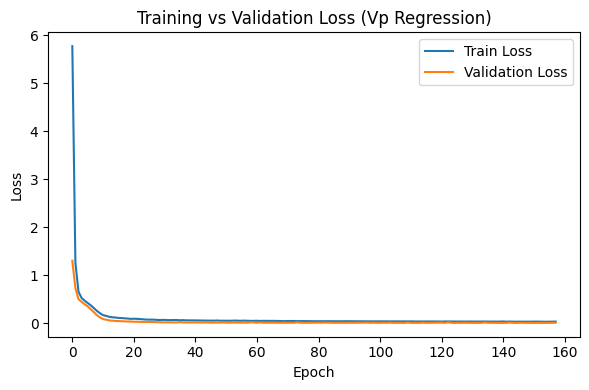

In [ ]:

plt.figure(figsize=(6,4))
plt.plot(history['train'], label='Train Loss')
plt.plot(history['val'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (Vp Regression)')
plt.legend()
plt.tight_layout()
plt.show()



## 7) Test Evaluation and Prediction Quality


Test MSE: 0.004208 | Test MAE: 0.049941 | Test R^2: 0.9974


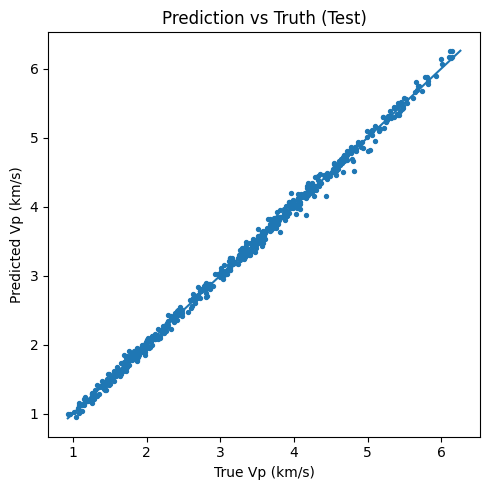

In [ ]:

def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            preds = model(xb).cpu().numpy()
            y_true.append(yb.numpy())
            y_pred.append(preds)
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    mse = np.mean((y_true - y_pred)**2)
    mae = np.mean(np.abs(y_true - y_pred))
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res/ss_tot
    return mse, mae, r2

test_mse, test_mae, test_r2 = evaluate(model, test_loader)
print(f"Test MSE: {test_mse:.6f} | Test MAE: {test_mae:.6f} | Test R^2: {test_r2:.4f}")

# Scatter plot
X_te, y_te = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        X_te.append(xb.numpy()); y_te.append(yb.numpy())
X_te = np.vstack(X_te); y_te = np.vstack(y_te)

with torch.no_grad():
    preds = model(torch.from_numpy(X_te).to(device)).cpu().numpy()

plt.figure(figsize=(5,5))
plt.scatter(y_te, preds, s=8)
lims = [min(y_te.min(), preds.min()), max(y_te.max(), preds.max())]
plt.plot(lims, lims)
plt.xlabel('True Vp (km/s)')
plt.ylabel('Predicted Vp (km/s)')
plt.title('Prediction vs Truth (Test)')
plt.tight_layout()
plt.show()



## 8) Exercises (Try These!)

1. **Activation Functions:** Try `activation='tanh'` or `leaky_relu` in `make_mlp`. Observe convergence and test $R^2$.
2. **Loss Functions:** Replace `nn.MSELoss()` with `nn.L1Loss()`. Which gives better robustness?
3. **Weight Decay (L2):** Increase `weight_decay` to `1e-3` or `5e-4`. Does validation loss improve?
4. **Dropout:** Try `dropout_p=0.3` or `0.5`. Is test error lower or higher?
5. **Optimizer:** Switch to `torch.optim.SGD(..., lr=1e-2, momentum=0.9)` and compare curves.
6. **Capacity:** Change `hidden=[64,64]` and `hidden=[256,256,256]`. Identify under/overfitting.
7. **Generalization Test:** Train on depths up to 1.5 km only; test on 1.5–3.0 km. How well does the model extrapolate?
8. **Inverse Task (Optional):** Predict porosity from (Vp, depth, lithology, fluid) by swapping inputs/targets and regenerating data.
